# Segmentation of mammo tiles

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#from fastai.core import *
from fastai import *
from fastai.vision import *
import PIL

from pathlib import *
import pandas as pd
import numpy as np
import colorcet as cc

#from gray_image import *
from fastai_gs import *

cmap_grey = cc.cm.linear_grey_0_100_c0

In [3]:
from enum import Enum
class ObsType(Enum):
    EMPTY=0           ,"empty"                   # outside the breast
    NORMAL=1          ,"normal"                  # tissue with no segments
    BENIGN_CALC=2     ,"benign_calcification"    # tissue with benign calcification
    MALIGNANT_CALC=3  ,"malignant calcification"  # tissue with malignant calcification
    BENIGN_MASS=4     ,"benign_mass"              # tissue with a benign node
    MALIGNANT_MASS=5  ,"malignant mass"           # tissue with a malignant node
def enum2int(e): return e.value[0]

def selectCases( cases, purpose, complexity, nb=1000 ): 
    dfAll = None
    for k,q in complexity.items():
        df  = cases[cases.purpose==purpose].query(q)
        df["classes"] = k
        idx   = np.unique(np.random.uniform( low=0, high=df.shape[0], size=10*nb).astype(int))
        idx   = idx[0:min(df.shape[0], nb, len(idx) )]
        dfAll = dfAll.append(df.iloc[idx]) if dfAll is not None else df.iloc[idx]
    return dfAll
 

In [4]:
path  = Path('../../data/mammography-data/mammography-dogscats-match-equalization-BINS-CHX/tiles') #print(list(path.iterdir()))
dxrays = "xrays"
dmasks = "obs_masks"
dtrain = "train"
dvalid = "test"

In [5]:
cases = pd.read_csv( path / "tiles.csv", sep=";", low_memory=False)
#print(f"cases.columns:{cases.columns}")
cases.drop("Unnamed: 0",axis=1,inplace=True)
#display(cases.tail(2))

#print("Stat of dataset before selection")
#gp = cases.groupby( ["purpose", "observation", "simple_pathology"])["fnImage"].count()
#print( gp )

codes = [obs.name.lower() for obs in ObsType]
#print(f"codes:{codes}")

complexity={
            "malignant_calc":"malignant_calc > 0.3*obsAreas and empty < 0.05*tile_size",
            "benign_calc":   "benign_calc    > 0.3*obsAreas and empty < 0.05*tile_size",
            "malignant_mass":"malignant_mass > 0.3*obsAreas and empty < 0.05*tile_size",
            "benign_mass":   "benign_mass    > 0.3*obsAreas and empty < 0.05*tile_size"
#50            "malignant_calc":"malignant_calc > 0.3*tile_size and benign_calc==0    and empty==0",
#50            "benign_calc":   "benign_calc    > 0.19*tile_size and malignant_calc==0 and empty==0"
#100            "malignant_calc":"malignant_calc > 0.2*tile_size and benign_calc==0    and empty==0",
#100            "benign_calc":   "benign_calc    > 0.2*tile_size and malignant_calc==0 and empty==0"
#500 samples           "malignant_calc":"malignant_calc > 0.037*tile_size and benign_calc==0    and empty==0",
#550 samples            "benign_calc":   "benign_calc    > 0.037*tile_size and malignant_calc==0 and empty==0"
#            "pHealthy":"pAir==0 and pBenign==0 and pMalignant==0",
#            "malignant_calc":"malignant_calc > 0.1*tile_size and malignant_calc > 0.5*obsAreas and benign_calc==0 and empty==0",
#            "pAir":"pAir>0.2 and pAir<1.0", 
#            "benign_calc":"benign_calc/tile_size>0.1 and benign_calc > 0.5*obsAreas and malignant_calc==0 and empty==0"
#            "pMalignant":"pMalignant > 0.99*obsAreas and pBenign==0 and pAir==0"
}
nb=1700

test   = selectCases( cases, "test",  complexity=complexity, nb=nb//2 )
train  = selectCases( cases, "train", complexity=complexity, nb=nb )
dfData = test.append(train)
print("Selected dataset"), display(dfData.head())
gp = dfData.groupby( ["purpose", "observation", "classes"])["fnImage"].count()
display( gp )


Selected dataset


,case_id,height,width,simple_pathology,patient_id,purpose,density,left_right,projection,obs id,...,malignant_calc,benign_mass,malignant_mass,rCenter,cCenter,tile_size,obsAreas,fnImage,fnMask,classes
131,Calc-Test_P_00127_RIGHT_CC,5375,2882,MALIGNANT,P_00127,test,2.0,RIGHT,CC,1,...,35066,0,0,0.55,0.46,1048576,48236,Calc-Test_P_00127_RIGHT_CC_tile_2435_809.png,Calc-Test_P_00127_RIGHT_CC_tile_2435_809.png,malignant_calc
132,Calc-Test_P_00127_RIGHT_CC,5375,2882,MALIGNANT,P_00127,test,2.0,RIGHT,CC,1,...,48709,0,0,0.59,0.62,1048576,48236,Calc-Test_P_00127_RIGHT_CC_tile_2670_1289.png,Calc-Test_P_00127_RIGHT_CC_tile_2670_1289.png,malignant_calc
133,Calc-Test_P_00127_RIGHT_CC,5375,2882,MALIGNANT,P_00127,test,2.0,RIGHT,CC,1,...,48460,0,0,0.64,0.40,1048576,48236,Calc-Test_P_00127_RIGHT_CC_tile_2918_628.png,Calc-Test_P_00127_RIGHT_CC_tile_2918_628.png,malignant_calc
146,Calc-Test_P_00127_RIGHT_MLO,5669,2615,MALIGNANT,P_00127,test,2.0,RIGHT,MLO,1,...,23367,0,0,0.85,0.50,1048576,41836,Calc-Test_P_00127_RIGHT_MLO_tile_4301_806.png,Calc-Test_P_00127_RIGHT_MLO_tile_4301_806.png,malignant_calc
147,Calc-Test_P_00127_RIGHT_MLO,5669,2615,MALIGNANT,P_00127,test,2.0,RIGHT,MLO,1,...,42245,0,0,0.75,0.49,1048576,41836,Calc-Test_P_00127_RIGHT_MLO_tile_3733_758.png,Calc-Test_P_00127_RIGHT_MLO_tile_3733_758.png,malignant_calc


purpose  observation    classes       
test     calcification  benign_calc        420
                        malignant_calc     261
         mass           benign_mass        673
                        malignant_mass     441
train    calcification  benign_calc       1700
                        malignant_calc    1156
         mass           benign_mass       1700
                        malignant_mass    1700
Name: fnImage, dtype: int64

In [6]:
#calculate the weights of the classes in the loss function
minWeight = 0
gp = dfData.groupby(["purpose"])[codes].mean().astype(np.int)

s = gp.sum(axis=1)
gp.iloc[0] /= s.iloc[0]
gp.iloc[1] /= s.iloc[1]

pd.options.display.float_format = '{:,.3f}'.format
print("Frequency of pixel pr class codes"), display(gp)

code_weights = 1. / (gp+1e-6)
code_weights[gp==0] = 0

s = code_weights.sum(axis=1)
code_weights.iloc[0] /= s.iloc[0]
code_weights.iloc[1] /= s.iloc[1]

print(f"\nWeights of observations")
display(code_weights)

#use the weight for training
code_weights = code_weights.iloc[0].values
code_weights = code_weights**0.95
code_weights /= np.sum(code_weights)
code_weights[code_weights==0] = minWeight

n=gc.collect()

Frequency of pixel pr class codes


,empty,normal,benign_calc,malignant_calc,benign_mass,malignant_mass
purpose,,,,,,
test,0.006,0.910,0.016,0.027,0.023,0.018
train,0.006,0.897,0.020,0.036,0.016,0.025



Weights of observations


,empty,normal,benign_calc,malignant_calc,benign_mass,malignant_mass
purpose,,,,,,
test,0.449,0.003,0.168,0.103,0.120,0.157
train,0.480,0.003,0.145,0.081,0.179,0.113


In [7]:
#np.exp(code_weights)-1
#code_weights[3]=0
code_weights

array([0.434032, 0.003785, 0.170816, 0.107573, 0.123556, 0.160239])

In [8]:
ixTrain  = dfData.purpose=="train"
ixValid  = ixTrain == False

train  = join_paths(dfData.fnImage[ixTrain].values, path/dtrain/dxrays)
valid  = join_paths(dfData.fnImage[ixValid].values, path/dvalid/dxrays)

get_y_fn   = lambda x: x.parents[1]/dmasks/x.name 
valid_func = lambda x: x.parts[-3] == dvalid

def open_image_16bit2rgb( fn ): 
    a = np.asarray(PIL.Image.open( fn ))
    a = np.expand_dims(a,axis=2)
    a = np.repeat(a, 3, axis=2)
    return Image( pil2tensor(a, np.float32 ).div(65535) )

vision.data.open_image = open_image_16bit2rgb

src = (SegmentationItemList( list(train+valid), create_func=open_image_16bit2rgb, path="")
                           .split_by_valid_func(valid_func)
                           .label_from_func(get_y_fn, classes=codes)           
      )

In [9]:
def getSegmentationTransforms():
    max_zoom        = 1.1
    max_rotate      = 0.1
    brightnes_range = (0.85, 1.01)
    contrast_range  = (0.85, 1.01)
    rotate_range    = (-10, 10) # degrees
    warp_range      = (-0.1, 0.1)
    
    tfmTrain,tfmValid =[],[]
    
    tfmTrain.append(crop_pad())
    tfmTrain.append( dihedral_affine() )
    
    """
    tfmTrain.append( rotate(degrees=rotate_range, p=.5) )
    #tfmTrain.append( flip_affine(p=0.5) )
    
    #tfmTrain.append( skew( np.arange, p=0.75) )
    tfmTrain.append( symmetric_warp(magnitude=warp_range, p=0.5) )
    #tfmTrain.append( perspective_warp(magnitude=warp_range, p=0.25) )
    
    #tfmTrain.append( rand_zoom(scale=(1.,max_zoom), p=0.75) )
    #tfmTrain.append( rand_crop() )

    tfmTrain.append( jitter(magnitude=0.01) )
    
    """
    if brightnes_range is not None: tfmTrain.append( brightness(change=brightnes_range, p=0.25) )
    if contrast_range is not None:  tfmTrain.append( contrast(scale=contrast_range,     p=0.25) )
    
        
    tfmValid.append(crop_pad())
    #tfmValid.append( flip_affine(p=0.5) )
    return (tfmTrain, tfmValid)

In [10]:
class ACC:          
    class_mask = torch.from_numpy( (code_weights > 0).astype(np.float32) )
    @staticmethod
    def accuracy_seg(input, target):
        #The input.argmax(dim=1) selects the winner class pr pixel, thereby reducing 
        #the input shape from (bs, classes, width, height) => (bs, width, height)
        #We, therefore, have to reshape the target tensor from (bs, 1, width, height) to (bs, width, height)
        sz     = target.size()
        target = target.reshape( (sz[0], sz[2], sz[3]) )

        #mask out classes with zeri weight
        if ACC.class_mask.lt(0).any() :
            mask = None
            for i in range(len(ACC.class_mask)):
                if ACC.class_mask[i] <= 0:
                    mask = target.eq(i).byte() if mask is None else mask + target.eq(i).byte()
                
            mask = mask.eq(0)
            return (input.argmax(dim=1)[mask].flatten()==target[mask].flatten()).float().mean()        #mask   = mask.reshape( (sz[0], sz[2], sz[3]) )
        else:
            return (input.argmax(dim=1).flatten()==target.flatten()).float().mean()

In [11]:
#ix_codes = torch.from_numpy( np.asarray( np.where(code_weights>0) ).flatten().astype(np.long) ).long().cuda()
#print(ix_codes)
def ignoreImageValues( class_images, class_mask, value=0):
    "set the pixel class to an ignore_index if the weight of the class is zero"
    for i in range(len(class_mask)):
        if class_mask[i] <= 0. :
            class_images[class_images==i] = value


class WeighedCrossEntropy(CrossEntropyFlat):
    msgBefore=""
    msgAfter=""
    msgRes=""
    msg=""
    def __init__( self, code_weights ):
        super(WeighedCrossEntropy, self).__init__()
        self.register_buffer("class_weights",  torch.from_numpy( code_weights).cuda() )
        self.register_buffer("ix_weights", torch.from_numpy( (code_weights>0).flatten().astype(np.float32) ) )
        self.ignore_index = -1
        print("ix_weights: ", self.ix_weights) 
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        scale  = 0.01
        #w      = torch_weigths_mult_noise(scale, self.weights )
        
        #WeighedCrossEntropy.msgAfter  = f"after: { input.size()}"
        #ignoreImageValues(target, ACC.class_mask, self.ignore_index )
        for i in range( self.ix_weights.shape[0] ) :
            if self.ix_weights[i] <= 0 : target[target==i] = self.ignore_index
        
        WeighedCrossEntropy.msg = f"{input.shape} - {target.shape} - {self.ignore_index}"
        
        n,c,rows,cols = input.shape
        return F.cross_entropy(input.view(n, c, -1), target.view(n, -1), weight=self.class_weights, 
                               ignore_index=self.ignore_index, reduction="sum"
                              )/(n*rows*cols)


In [12]:
#bs,size=100,64
#bs,size=32,128
#bs,size=64,128 
#bs,size=16,128 
bs,size=16,224 
#bs,size=4,512 
data = ( src.transform(getSegmentationTransforms(), size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats) )
#data.show_batch(2, figsize=(10,7))

In [13]:
loss_func = WeighedCrossEntropy( code_weights.astype(np.float32) ) # DiceLoss() #WeighedCrossEntropy( code_weights.astype(np.float32) ) # # FocalLoss(gamma=2.,alpha=.25), #  
#                            loss_func=  WeighedCrossEntropy( torch.from_numpy( code_weights.astype(np.float32) ).cuda() ), # DiceLoss(), # FocalLoss(gamma=2.,alpha=.25), #  
learn = Learner.create_unet(data, 
                            models.resnet34, 
                            loss_func= loss_func,
                            metrics=ACC.accuracy_seg
                           )


ix_weights:  tensor([1., 1., 1., 1., 1., 1.])


lr=1e-6
learn.fit_one_cycle(1, slice(lr))

learn.loss_func = WeighedCrossEntropy( code_weights.astype(np.float32) )

In [ ]:
n = gc.collect()
torch.cuda.empty_cache()
lr_find(learn)

In [ ]:
learn.recorder.plot(skip_end=5)

In [14]:
lr=0.8e-3
learn.fit_one_cycle(3, slice(lr), wd=0.15, moms = (0.97,0.87) )
n=gc.collect()
torch.cuda.empty_cache()

Total time: 03:56
epoch  train_loss  valid_loss  accuracy_seg
1      0.024347    0.021825    0.536020      (01:18)
2      0.023778    0.020359    0.471342      (01:19)
3      0.021819    0.019876    0.567661      (01:18)



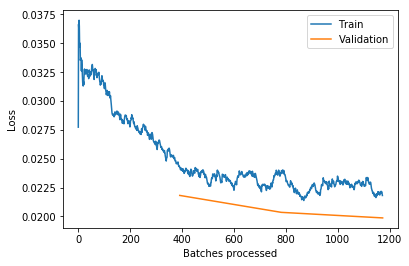

In [15]:
learn.recorder.plot_losses()

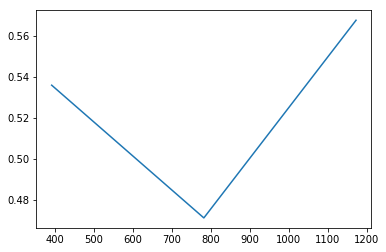

In [16]:
learn.recorder.plot_metrics()

In [17]:
learn.opt.wd

0.15

In [18]:
print("code_weights:", code_weights)

code_weights: [0.434032 0.003785 0.170816 0.107573 0.123556 0.160239]


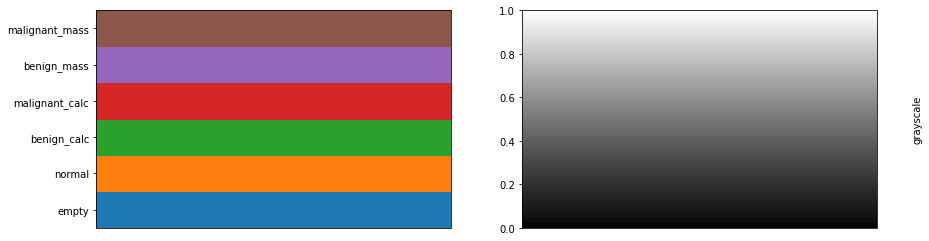

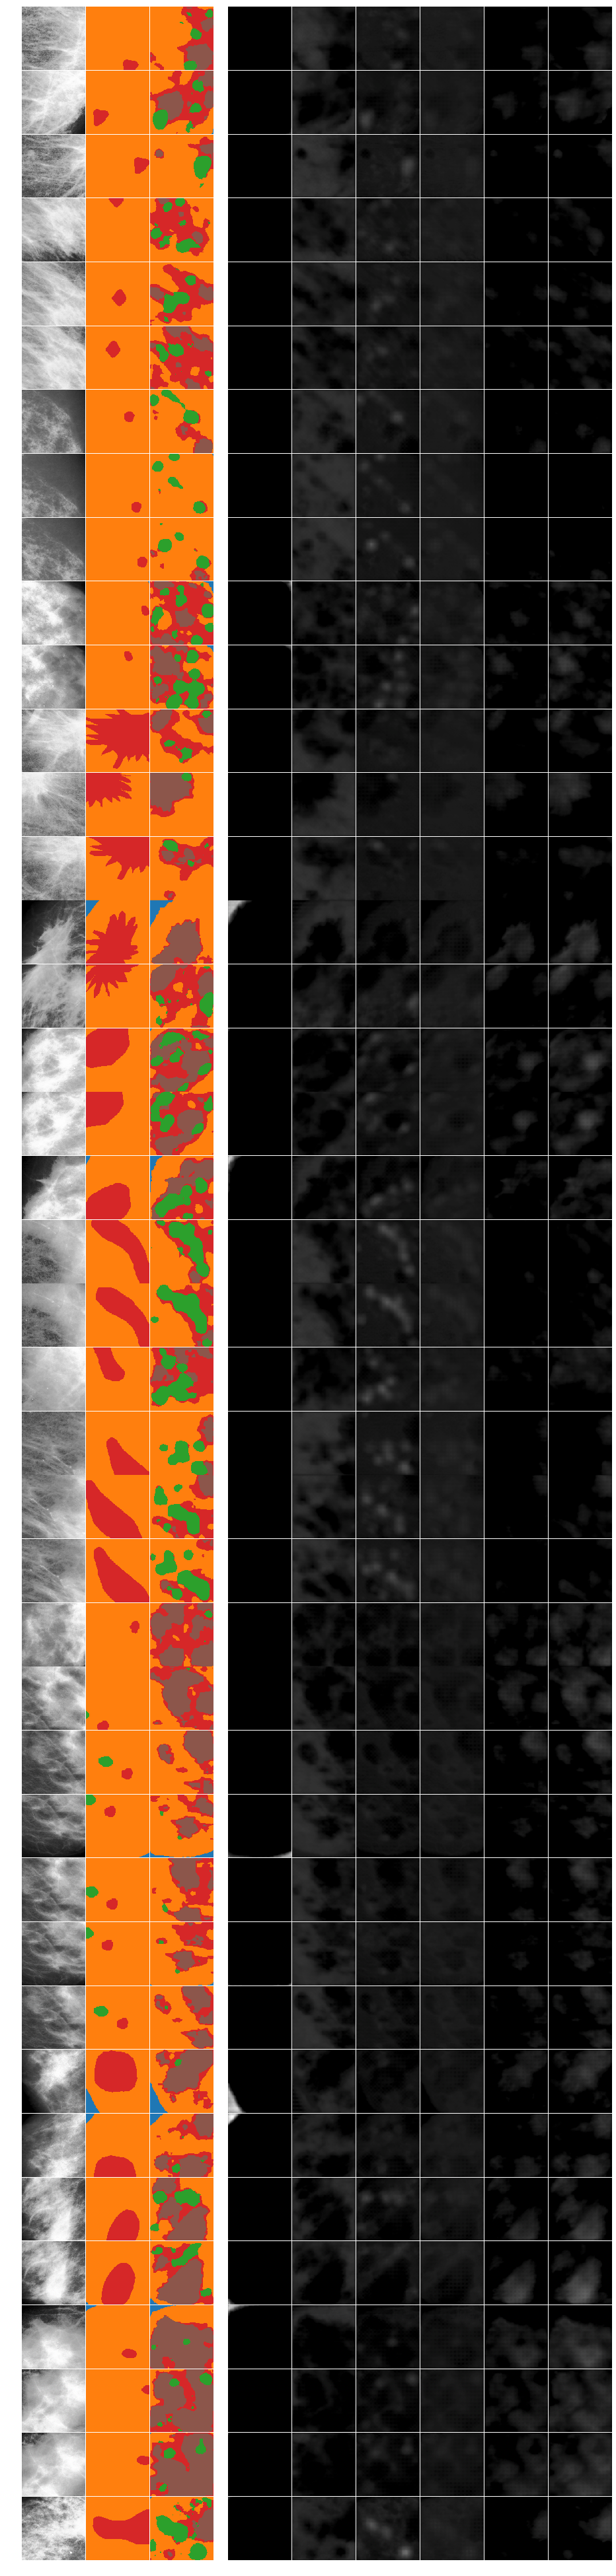

In [19]:
plotPreds(learn, nrows=40, codes=codes, code_weights=code_weights, ds_type=DatasetType.Valid)  

In [20]:
xs,ys,ps,pcs = getIO(learn, 1, ds_type=DatasetType.Train, class_mask=code_weights)

In [21]:
print(pcs[0].min())
print(pcs[0].max())

-4.6291676
2.502771


In [ ]:
learn.save('resnet34-stage-1')
n=gc.collect()
torch.cuda.empty_cache()

In [ ]:
learn.load('resnet34-stage-1');

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
multilayer_lr=slice(1e-6,lr/5)
learn.fit_one_cycle(15, multilayer_lr)

In [ ]:
learn.recorder.plot_losses(), plt.show(), learn.recorder.plot_metrics()

In [ ]:
plotPreds(learn, nrows=20, codes=codes, code_weights=code_weights, ds_type=DatasetType.Train)   

In [ ]:
learn.save('resnet34-stage-2');

In [ ]:
learn.load('resnet34-stage-2');